In [38]:
!pip install pyramid-arima

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [39]:
pyramid.__version__
print("pyramid version",pyramid.__version__)
import pip; print("pip version",pip.__version__)

'0.8.1'

pyramid version 0.8.1
pip version 9.0.1


In [40]:
import warnings
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pyramid as pm
from sklearn import metrics
from pyramid.arima import auto_arima
warnings.filterwarnings ('ignore')


In [41]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity="all"

In [42]:
flight_data = sns.load_dataset("flights") 
flight_data.tail()
flight_data.shape
flight_data.describe()
flight_data.info()

,year,month,passengers
139,1960,August,606
140,1960,September,508
141,1960,October,461
142,1960,November,390
143,1960,December,432


(144, 3)

,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
year          144 non-null int64
month         144 non-null category
passengers    144 non-null int64
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [43]:
flight_data_pivot=flight_data.pivot('month','year','passengers')
flight_data_pivot

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


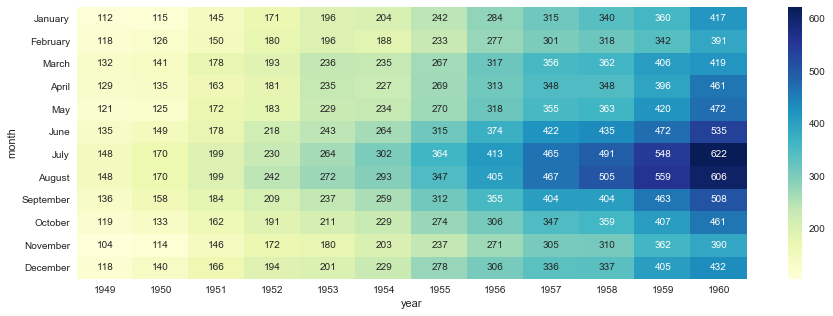

In [44]:
plt.figure(figsize=(15,5))
sns.heatmap(flight_data_pivot, annot=True, fmt='d',cmap="YlGnBu")
plt.show();

In [45]:
#Create a date range variable which captures date range of the above data

In [46]:
month = pd.date_range('19490131',periods=144,freq='M')
month

DatetimeIndex(['1949-01-31', '1949-02-28', '1949-03-31', '1949-04-30',
               '1949-05-31', '1949-06-30', '1949-07-31', '1949-08-31',
               '1949-09-30', '1949-10-31',
               ...
               '1960-03-31', '1960-04-30', '1960-05-31', '1960-06-30',
               '1960-07-31', '1960-08-31', '1960-09-30', '1960-10-31',
               '1960-11-30', '1960-12-31'],
              dtype='datetime64[ns]', length=144, freq='M')

In [47]:
#Insert the datetime column in the original table
flight_data['datestamp']=month
flight_data.head()

,year,month,passengers,datestamp
0,1949,January,112,1949-01-31
1,1949,February,118,1949-02-28
2,1949,March,132,1949-03-31
3,1949,April,129,1949-04-30
4,1949,May,121,1949-05-31


In [48]:
data = flight_data.loc[:,('datestamp','passengers')]
data.head()
data.describe()

,datestamp,passengers
0,1949-01-31,112
1,1949-02-28,118
2,1949-03-31,132
3,1949-04-30,129
4,1949-05-31,121


,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [49]:
#Reindex using method "set_index" the data on datetime variable


In [50]:
data.set_index('datestamp', inplace = True)
data.head()

,passengers
datestamp,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


In [51]:
#plot the timeseries data, add x label,y label and title

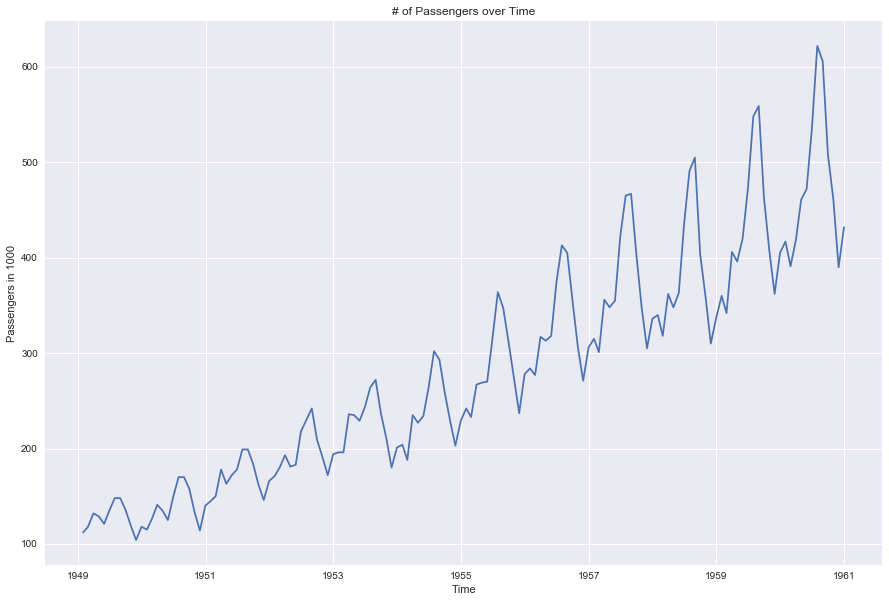

In [52]:
plt.figure(figsize=(15,10))
plt.plot(data.passengers)
plt.xlabel("Time")
plt.ylabel("Passengers in 1000")
plt.title('# of Passengers over Time')
plt.show;

In [53]:
#Decompose timeseries to trend, seasonal and random components using multiplicative model

In [54]:
decomposition = seasonal_decompose(data, model='multiplicative')

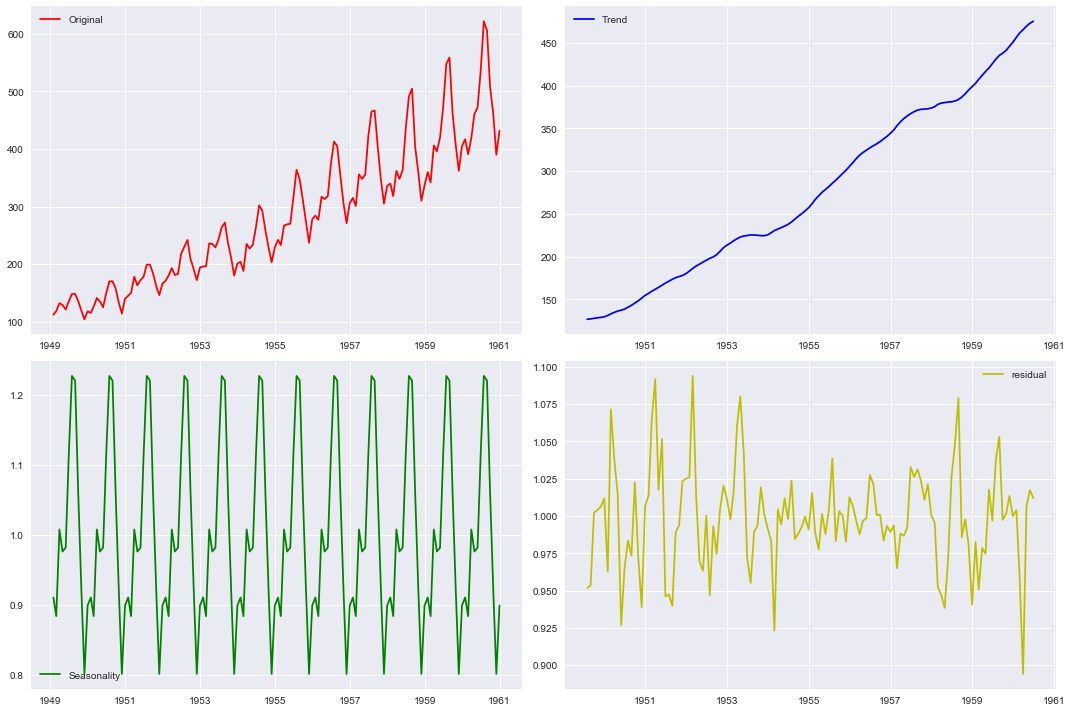

In [55]:
#Plot trend of the series
plt.figure(figsize=(15,10))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(221)
plt.plot(data,'r', label = 'Original')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,'b', label = 'Trend')
plt.legend(loc='best')
plt.subplot(223)
plt.plot(seasonal,'g', label = 'Seasonality')
plt.legend(loc='best')
plt.subplot(224)
plt.plot(residual,'y', label = 'residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show();

In [56]:
#Test for the stationarity of the time series

In [59]:
from pyramid.arima.stationarity import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.is_stationary(data)

(0.98999999999999999, False)

In [60]:
#Split the data in train and test datasets

In [63]:
train,test = data[:100],data[100:]
train.shape
test.shape

(100, 1)

(44, 1)

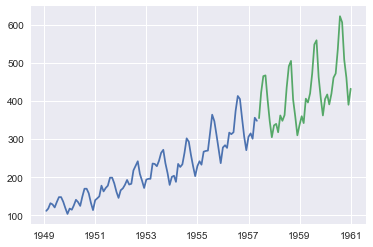

In [64]:
plt.plot(train)
plt.plot(test)
plt.show();

In [67]:
#Fitting a stepwise model:
from pyramid.arima import auto_arima

Arima_model= auto_arima(train,start_p=1,start_q=1,max_p=8,max_q=8,start_P=0,start_Q=0,max_P=8,max_Q=8,m=12,
                       seasonal=True,trace=True,d=1,D=1,error_action='warn',suppress_warnings=True,
                       stepwise=True, random_state= 20,n_fits= 30)
Arima_model.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=649.156, BIC=659.019, Fit time=0.450 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=652.680, BIC=657.612, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=645.943, BIC=655.806, Fit time=0.226 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=646.447, BIC=656.311, Fit time=0.172 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=647.792, BIC=655.190, Fit time=0.071 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=647.917, BIC=660.247, Fit time=0.538 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=647.931, BIC=660.261, Fit time=0.279 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=645.798, BIC=660.594, Fit time=1.819 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=652.514, BIC=664.843, Fit time=0.662 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(2, 1, 1, 12)   Log Likelihood                -316.899
Date:                            Sat, 27 Oct 2018   AIC                            645.798
Time:                                    13:10:23   BIC                            660.594
Sample:                                         0   HQIC                           651.756
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0061      0.274      0.022      0.982      -0.532       0.544
ar.L1         -0.3025      0.097     -3.122      0.002      -0.492      -0.113
ar.S.L12       0.6820      0.123      5.526      0.000       0.440       0.924
ar.S.L24       0.3161      0.101      3.140      0.002       0.119       0.513
ma.S.L12      -0.9759      0.535     -1.824      0.068      -2.025       0.073
sigma2        76.2499     36.245      2.104      0.035       5.211     147.289
===================================================================================
Ljung-Box (Q):                       39.55   Jarque-Bera (JB):                 3.16
Prob(Q):                              0.49   Prob(JB):                         0.21
Heteroskedasticity (H):               1.31   Skew:                             0.47
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
prediction = pd.DataFrame(Arima_model.predict(n_periods=44), index = test.index)
prediction.columns = ['Predicted_Passengers']
prediction

,Predicted_Passengers
datestamp,
1957-05-31,355.033093
1957-06-30,411.301036
1957-07-31,456.714419
1957-08-31,444.663964
1957-09-30,395.490722
1957-10-31,346.826113
1957-11-30,308.959457
1957-12-31,349.224662
1958-01-31,359.273058


In [72]:
test.head()

,passengers
datestamp,
1957-05-31,355
1957-06-30,422
1957-07-31,465
1957-08-31,467
1957-09-30,404


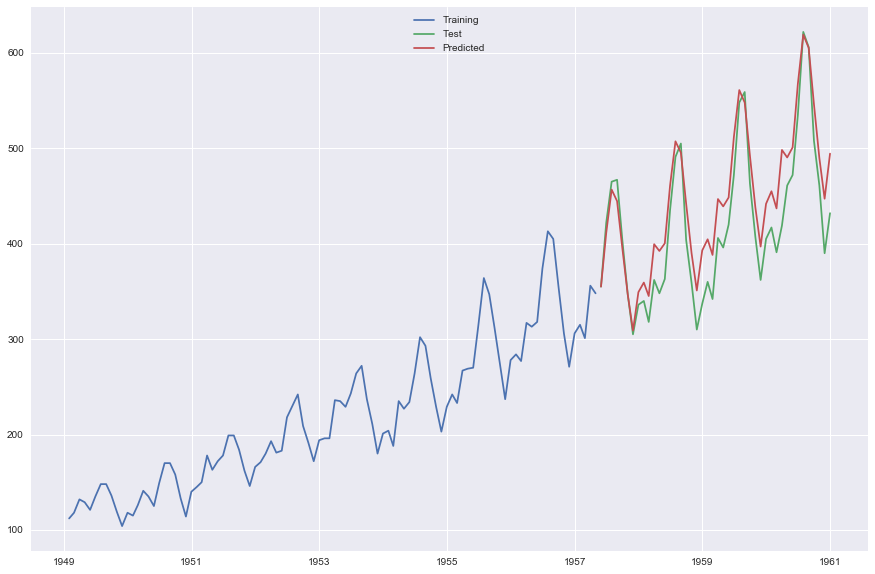

In [73]:
plt.figure(figsize=(15,10))
plt.plot(train,label="Training")
plt.plot(test, label="Test")
plt.plot(prediction, label="Predicted")
plt.legend(loc= 'upper center')
plt.show();

In [76]:
test['Predicted_Passengers']=prediction
test['Error']= test['passengers']-test['Predicted_Passengers']
test

,passengers,predicted_passengers,predicted_Passengers,Predicted_Passengers,Error
datestamp,,,,,
1957-05-31,355,355.033093,355.033093,355.033093,-0.033093
1957-06-30,422,411.301036,411.301036,411.301036,10.698964
1957-07-31,465,456.714419,456.714419,456.714419,8.285581
1957-08-31,467,444.663964,444.663964,444.663964,22.336036
1957-09-30,404,395.490722,395.490722,395.490722,8.509278
1957-10-31,347,346.826113,346.826113,346.826113,0.173887
1957-11-30,305,308.959457,308.959457,308.959457,-3.959457
1957-12-31,336,349.224662,349.224662,349.224662,-13.224662
1958-01-31,340,359.273058,359.273058,359.273058,-19.273058


In [77]:
metrics.mean_absolute_error(test.passengers,test.Predicted_Passengers)

29.40765532097312

In [78]:
metrics.mean_squared_error(test.passengers, test.Predicted_Passengers)

1178.4277487502534

In [79]:
metrics.median_absolute_error(test.passengers,test.Predicted_Passengers)

30.198285917632006

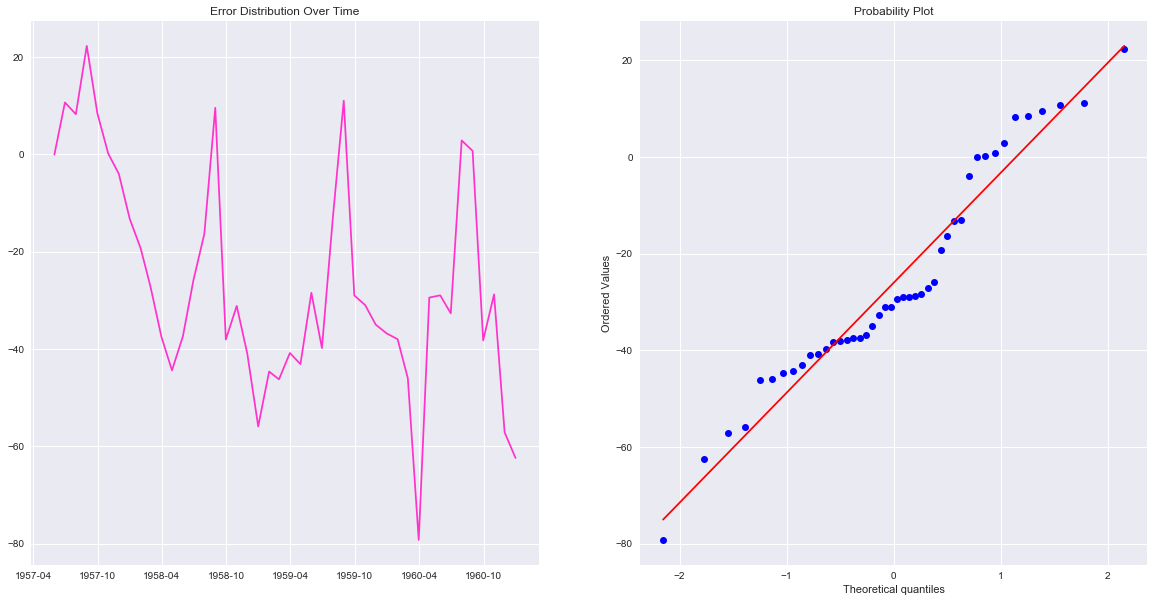

In [80]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(test.Error,color= '#ff33CC')
plt.title('Error Distribution Over Time')
plt.subplot(122)
scipy.stats.probplot(test.Error,plot=plt)
plt.show();


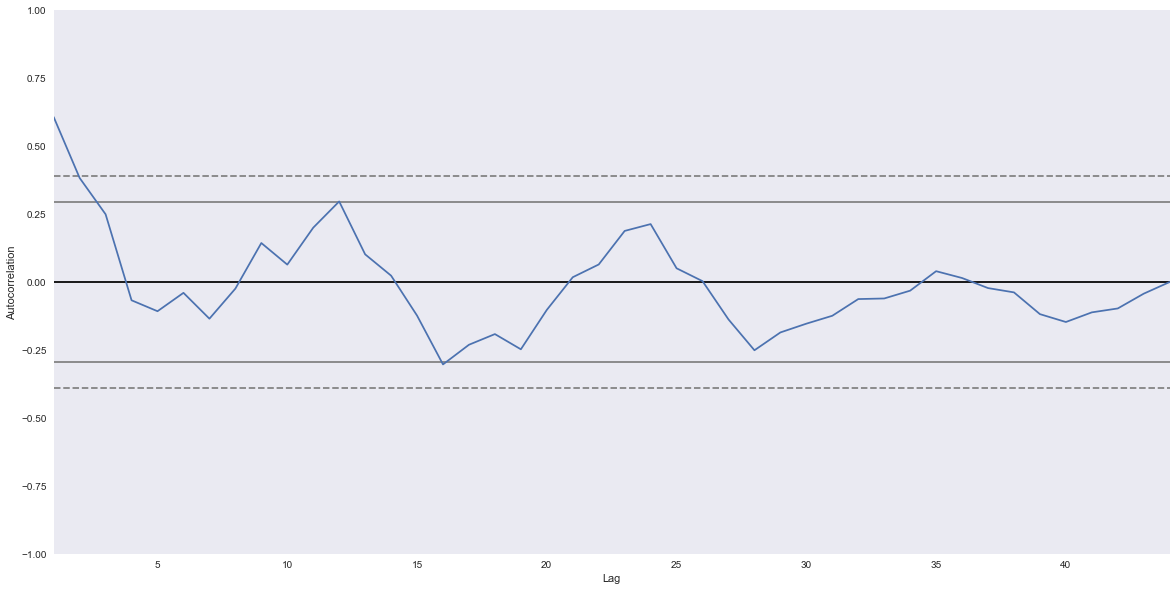

In [81]:
plt.figure(figsize=(20,10))
pm.autocorr_plot(test.Error)
plt.show();